In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

torch.cuda.is_available()

True

In [3]:
class LSTM(nn.Module):

    def __init__(self, num_output, num_features,
                 hidden_size, num_layers, is_cuda: bool = False):
        ## hidden_size is like embedding feature space dimension
        ## better > num_assets?
        ## if num_layers = 2: stack 2 LSTM of lyaer 1:
        # nn.Sequential(OrderedDict([
        #     ('LSTM1', nn.LSTM(input_size, hidden_size, 1),
        #     ('LSTM2', nn.LSTM(hidden_size, hidden_size, 1)
        #     ]))
        super(LSTM, self).__init__()
        self.num_output = num_output
        self.num_layers = num_layers
        self.num_features = num_features
        self.hidden_size = hidden_size
        # self.window_size = window_size

        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_output)

        self.is_cuda = is_cuda

        if is_cuda:
            self.lstm.cuda()
            self.dropout.cuda()
            self.fc.cuda()

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        batch_size = x.shape[0]
        # the second dim for h_0 and c_0 is the batch dim
        # hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)
        # cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)

        if self.is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        # print(x.device)
        # print(list(x.device for x in self.lstm.parameters()))
        # print(h_0.device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # get only the last hidden layer, needed for multiple layer
        h_out = h_out[-1, :, :].view(-1, self.hidden_size)

        out = self.fc(self.dropout(h_out))

        return out


In [4]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # patience: num of times allowed for new_loss > old_loss+delta
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [11]:
import pandas as pd
from pipeline import Dataset, backtest
from matplotlib import pyplot as plt
from datatools import data_quantization, check_dataframe, extract_market_data
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm, trange
from pandas import Series, DataFrame, MultiIndex
from visualization.metric import Performance
from sklearn.metrics import r2_score
from visualization.metric import plot_performance
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

In [6]:
dataset = Dataset.load('../../data/parsed')
# dataset = load_mini_dataset('../../data/parsed_mini/')

In [ ]:
from qids_lib import QIDS

qids = QIDS(path_prefix='../../')

In [ ]:
m_df = extract_market_data(dataset.market)

In [ ]:
# quantized_fundamental, _ = data_quantization(dataset.fundamental)
df = pd.concat([m_df, dataset.fundamental, dataset.ref_return], axis=1).dropna()
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                    'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']

check_dataframe(df, expect_index=['day', 'asset'])


In [ ]:
df['return_known'] = df['return'].shift(2 * 54).fillna(0)
df['return_1'] = df['return_0'].shift(54).fillna(0)
df = df.dropna()

In [ ]:
df

In [ ]:
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe', 'pcf', 'return_0', 'return_1']

## Training only use the current data (one data one training each fold)

In [ ]:
# Hyperparameter
n_splits = 995
n_epoch = 3
learning_rate = 0.01
lookback_window = 16
# Define loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# Define feature
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_known']
feature_columns = original_feature
return_column = ['return']
num_features = len(feature_columns)

In [ ]:
class NN_wrapper():
    def __init__(self, lr=0.001, criterion=nn.MSELoss(), n_epoch=100, n_feature=7, train_lookback=32, eval_lookback=16,
                 n_asset=54, gamma=0.93, preprocess=None):
        self.preprocess = preprocess
        self.net = LSTM(num_output=1, num_features=n_feature, hidden_size=512, num_layers=1, is_cuda=True)
        self.n_epoch = n_epoch
        self.criterion = criterion
        self.train_lookback = train_lookback
        self.eval_lookback = eval_lookback
        self.n_asset = n_asset

        # Define the optimizier
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999))
        self.gamma = gamma
        self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=lr/10, max_lr=lr, step_size_up=n_epoch//2, cycle_momentum=False)

        # self.scaler = MinMaxScaler()
        # self.early_stopper = EarlyStopper(patience=3, min_delta=10)

    def fit_predict(self, X_, y_):
        self.net.train()
        # X_transformed = self.preprocess.fit_transform(X)
        # X_transformed = X

        X = xr.Dataset.from_dataframe(X_)
        y = xr.DataArray.from_series(y_)

        X_pd = X.to_dataframe(dim_order=['day', 'asset'])
        X_transformed_pd = self.preprocess.fit_transform(X_pd)
        X_transformed = xr.Dataset.from_dataframe(X_transformed_pd)

        start_day = X_transformed.day.min().to_numpy().item()

        X_ult = torch.cat([torch.from_numpy(
            X_transformed.sel(day=slice(start_day + i, start_day + i + self.eval_lookback - 1))
                .to_array(dim='feature').transpose('asset', 'day', 'feature')
                .to_numpy()) for i in range(self.train_lookback)
        ], dim=0).to(torch.float).cuda()
        y_ult = torch.cat([torch.from_numpy(
            y.sel(day=start_day + i + self.eval_lookback - 1)
                .to_numpy()) for i in range(self.train_lookback)
        ], dim=0).to(torch.float).cuda()

        # print(X_ult.shape)
        # print(y_ult.shape)

        for epoch in range(self.n_epoch):
            # print('its actually training')
            def closure():
                self.optimizer.zero_grad()
                outputs = self.net(X_ult)
                loss = self.criterion(outputs, y_ult)
                loss.backward()
                return loss

            self.optimizer.zero_grad()
            outputs = self.net(X_ult).squeeze()
            loss = self.criterion(outputs, y_ult)
            # print(loss)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            # print(self.scheduler.get_last_lr())

        return outputs.cpu().detach().numpy()

    def predict(self, X):
        self.net.eval()
        X_transformed = self.preprocess.transform(X)
        # X_transformed = X
        # X_np = X_transformed.swaplevel(1, 0).sort_index(ascending=True).to_numpy().astype(np.float32)
        # X_np = self.preprocess.transform(X_np)
        # shape (asset, days, feature) -> (ft, days, asset)
        # X_np_tensor = X_np.reshape(self.n_asset, self.eval_lookback, -1)
        # X_np_tensor = X_np_tensor[np.newaxis, :]  # add batch dimension
        # X_torch = torch.from_numpy(X_np_tensor).cuda()
        
        X_torch = torch.from_numpy(xr.Dataset.from_dataframe(X_transformed).to_array(dim='feature')
                                   .transpose('asset', 'day', 'feature').to_numpy()).to(torch.float).cuda()
        
        y = self.net(X_torch)
        # return np.clip(y.detach().numpy(), -0.2, 0.2)
        return y.cpu().squeeze().detach().numpy()

In [ ]:
from model.neural_network import DataPreprocessing
from pipeline.backtest import cross_validation

feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_0', 'return_1']
train_lookback = 8
eval_lookback = 16
preprocess = DataPreprocessing()
model = NN_wrapper(lr=5e-4, n_epoch=10, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess)
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model, feature, df.loc[idx[200:, :], :], train_lookback=train_lookback, per_eval_lookback=eval_lookback)

In [ ]:

plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.ylim([-0.3, 0.4])
plt.show()


In [ ]:
from model.neural_network import DataPreprocessing
from pipeline.backtest import cross_validation

feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_0', 'return_1']
train_lookback = 8
eval_lookback = 16
preprocess5 = DataPreprocessing()
model5 = NN_wrapper(lr=5e-4, n_epoch=5, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess5)
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model5, feature, df.loc[idx[200:, :], :], train_lookback=train_lookback, per_eval_lookback=eval_lookback)

In [ ]:

plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.ylim([-0.3, 0.4])
plt.show()


In [ ]:
from model.neural_network import DataPreprocessing
from pipeline.backtest import cross_validation

feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_0', 'return_1']
train_lookback = 8
eval_lookback = 16
preprocess2 = DataPreprocessing()
model2 = NN_wrapper(lr=5e-4, n_epoch=2, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess2)
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model5, feature, df.loc[idx[200:, :], :], train_lookback=train_lookback, per_eval_lookback=eval_lookback)

In [ ]:
torch.save(model5.net, '../../model/5.pt')

In [ ]:
from pipeline.backtest import evaluation_for_submission

performance5_eval = evaluation_for_submission(model5, dataset, qids, lookback_window=train_lookback, per_eval_lookback=eval_lookback)

In [ ]:
plt.figure(0)
plot_performance(performance5_eval, metrics_selected=['train_r2', 'test_cum_pearson', 'test_cum_r2'])

plt.ylim([-0.3, 0.4])
plt.show()

In [ ]:
from pipeline.backtest import evaluation_for_submission

preprocess55 = DataPreprocessing()
model55 = NN_wrapper(lr=5e-4, n_epoch=5, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess55)
performance5_eval = evaluation_for_submission(model55, dataset, qids, lookback_window=train_lookback, per_eval_lookback=eval_lookback)

The ending score for metric train_r2 is: 3.7789e-01
The ending score for metric val_cum_r2 is: -2.7442e-01
The ending score for metric val_cum_pearson is: 1.3327e-02


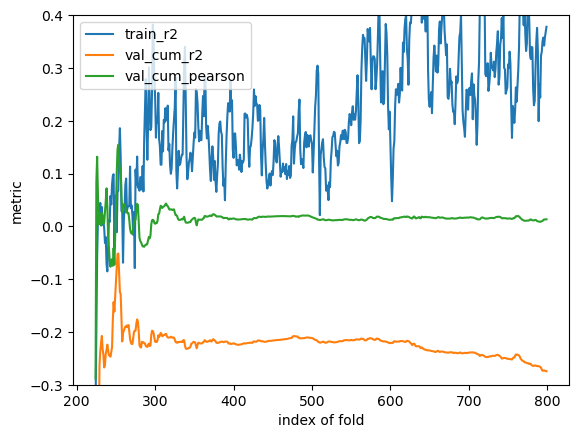

In [42]:

plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.ylim([-0.3, 0.4])
plt.show()


In [43]:
from model.neural_network import DataPreprocessing
from pipeline.backtest import cross_validation

feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_0', 'return_1']
train_lookback = 8
eval_lookback = 16
preprocess5 = DataPreprocessing()
model5 = NN_wrapper(lr=5e-4, n_epoch=5, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess5)
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model5, feature, df.loc[idx[200:, :], :], train_lookback=train_lookback, per_eval_lookback=eval_lookback)

Validation on day 799, train_r2=0.0532, val_r2=-0.1389, val_cum_r2=-0.1398, val_cum_pearson=0.0140: 100%|██████████| 576/576 [01:27<00:00,  6.59it/s]  


The ending score for metric train_r2 is: 5.3246e-02
The ending score for metric val_cum_r2 is: -1.3978e-01
The ending score for metric val_cum_pearson is: 1.4012e-02


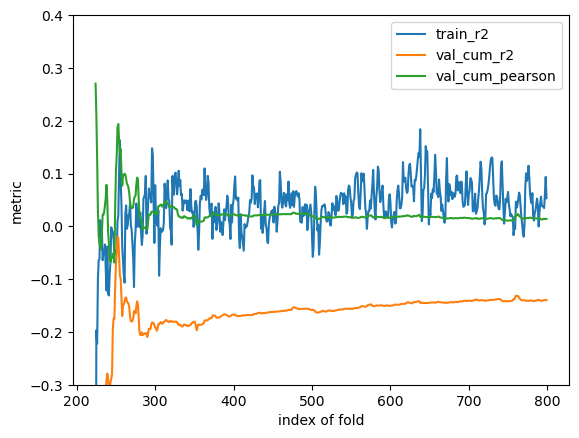

In [44]:

plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.ylim([-0.3, 0.4])
plt.show()


In [45]:
from model.neural_network import DataPreprocessing
from pipeline.backtest import cross_validation

feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_0', 'return_1']
train_lookback = 8
eval_lookback = 16
preprocess2 = DataPreprocessing()
model2 = NN_wrapper(lr=5e-4, n_epoch=2, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess2)
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model5, feature, df.loc[idx[200:, :], :], train_lookback=train_lookback, per_eval_lookback=eval_lookback)

Validation on day 799, train_r2=0.0826, val_r2=-0.2084, val_cum_r2=-0.1525, val_cum_pearson=0.0003: 100%|██████████| 576/576 [01:27<00:00,  6.61it/s]  


In [48]:
torch.save(model5.net, '../../model/5.pt')

In [51]:
from pipeline.backtest import evaluation_for_submission

performance5_eval = evaluation_for_submission(model5, dataset, qids, lookback_window=train_lookback, per_eval_lookback=eval_lookback)

Day 1700, test cum pearson -0.0320: 100%|█████████▉| 699/700 [02:34<00:00,  4.52it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: 5.6445e-02
The ending score for metric test_cum_r2 is: -1.8896e-01
The ending score for metric test_cum_pearson is: -3.2040e-02


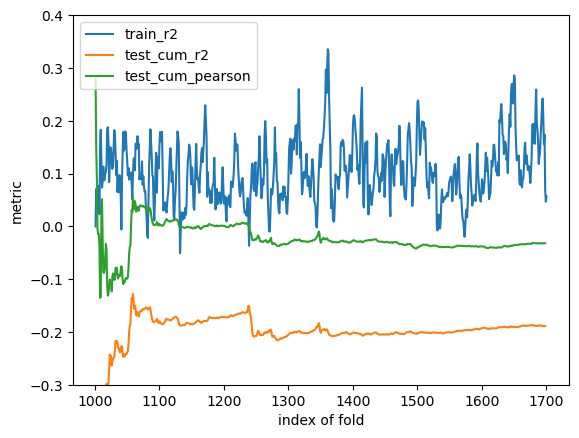

In [52]:
plt.figure(0)
plot_performance(performance5_eval, metrics_selected=['train_r2', 'test_cum_pearson', 'test_cum_r2'])

plt.ylim([-0.3, 0.4])
plt.show()

In [53]:
from pipeline.backtest import evaluation_for_submission

preprocess55 = DataPreprocessing()
model55 = NN_wrapper(lr=5e-4, n_epoch=5, train_lookback=train_lookback, eval_lookback=eval_lookback, gamma=0.95, preprocess=preprocess55)
performance5_eval = evaluation_for_submission(model55, dataset, qids, lookback_window=train_lookback, per_eval_lookback=eval_lookback)

Day 1700, test cum pearson -0.0241: 100%|█████████▉| 699/700 [02:35<00:00,  4.49it/s]

Data Feeding is finished.


In [10]:
# Hyperparameter
n_splits = 995
n_epoch = 3
learning_rate = 0.01
lookback_window = 16
# Define loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# Define feature
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_known']
feature_columns = original_feature
return_column = ['return']
num_features = len(feature_columns)

# Define network
net = LSTM(num_output=1,  #only the return
           num_features=num_features,
           hidden_size=1024, num_layers=1).cuda()

# Define the optimizier
# optimizer = optim.LBFGS(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

train_loss_list = []
# label_train_list = []
val_loss_list = []
# test_score_old = 0
days = df.index.get_level_values('day').unique()
tscv = TimeSeriesSplit(n_splits=min(n_splits, len(days)))

scaler = MinMaxScaler()
early_stopper = EarlyStopper(patience=3, min_delta=10)

for epoch in range(n_epoch):

    torch.manual_seed(3407)
    pbar = tqdm(tscv.split(days), total=tscv.n_splits)

    cum_y_val_true = Series(dtype=float)
    cum_y_val_prediction = Series(dtype=float)
    performance = Performance()
    # feature_columns = quantile_feature
    train_loss = 0
    val_loss = 0
    # np.random.seed(44)
    # for epoch in range(n_epoch):
    for fold, (train, val) in enumerate(pbar):
        # X, _ = data_quantization(df[original_feature])
        running_loss = 0
        days_train = days[train]

        if len(days_train) < 2:
            print('Skipping this fold since we cannot truncate the last day.')
            continue
        if (lookback_window is not None) and (len(days_train) > lookback_window):
            cum_y_train_true = Series(dtype=float)
            cum_y_train_prediction = Series(dtype=float)

            days_train_valid = days_train[-lookback_window - 1:-1]  # last ends at valid-day-2
            X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid[-1]), :][
                return_column]

            X_np = X_train.swaplevel(1, 0).sort_index(ascending=True).to_numpy().astype(np.float32)
            X_np = scaler.fit_transform(X_np)
            # X_np_tensor = X_np.reshape(54,lookback_window,-1).transpose([2,1,0])
            X_np_tensor = X_np.reshape(54, lookback_window, -1)
            # shape (asset, days, feature)  LSTM Shape: (batch(first), seq_len, feature)
            # X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
            X_torch = torch.from_numpy(X_np_tensor)
            labels = torch.tensor(y_train_true['return'].values).to(torch.float)  #


            def closure():
                optimizer.zero_grad()
                outputs = net(X_torch)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss


            net.train()
            optimizer.zero_grad()
            outputs = net(X_torch)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            # optimizer.step(closure) # need closure for LBFGS
            optimizer.step()

            scheduler.step()  ### !!!!!
            cum_y_train_prediction = pd.concat([cum_y_train_prediction, Series(outputs.detach().numpy().squeeze())])
            cum_y_train_true = pd.concat([cum_y_train_true, y_train_true.squeeze()], ignore_index=True)

            performance[fold, 'train_r2'] = r2_score(cum_y_train_prediction, cum_y_train_true)
            if fold % 100 == 0:
                print('Fold [{}/{}], Loss: {:.4f}, cum_train_r2: {:.2f}%'.format(fold, len(pbar), loss.item(),
                                                                                 r2_score(cum_y_train_prediction,
                                                                                          cum_y_train_true)))
            # loss_list.append(loss.item())
            train_loss += loss.item()

            # Validation:
            days_val = days[int(val) - lookback_window:int(val)]

            X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val[-1],), :][return_column]
            net.eval()
            with torch.no_grad():
                X_np_val = X_val.swaplevel(1, 0).sort_index(ascending=True).to_numpy().astype(np.float32)
                X_np_val = scaler.fit_transform(X_np_val)
                # shape (asset, days, feature) -> (ft, days, asset)
                X_np_val_tensor = X_np_val.reshape(54, lookback_window, -1)
                # X_np_val_tensor = X_np_val_tensor[np.newaxis,:]  # add batch dimension
                X_torch_val = torch.from_numpy(X_np_val_tensor)
                labels_val = torch.tensor(y_val_true['return'].values).to(torch.float)

                outputs_val = net(X_torch_val)
                loss_val = criterion(outputs_val.squeeze(), labels_val)
                val_loss += loss_val.item()

                cum_y_val_prediction = pd.concat([cum_y_val_prediction, Series(outputs_val.numpy().squeeze())])
                cum_y_val_true = pd.concat([cum_y_val_true, y_val_true.squeeze()], ignore_index=True)

            val_r2 = r2_score(y_val_true.squeeze(),
                              Series(outputs_val.numpy().squeeze()))  # Do I need index for series to corr or R2?
            performance[fold, 'val_r2'] = val_r2
            val_pearson = y_val_true.squeeze().corr(Series(outputs_val.numpy().squeeze()))
            performance[fold, 'val_pearson'] = val_pearson
            val_cum_r2 = r2_score(cum_y_val_true, cum_y_val_prediction)
            performance[fold, 'val_cum_r2'] = val_cum_r2
            val_cum_pearson = cum_y_val_true.corr(cum_y_val_prediction)
            performance[fold, 'val_cum_pearson'] = val_cum_pearson

            pbar.set_description(f'Fold {fold}, val_cum_r2={val_cum_r2:.4f}, val_cum_pearson={val_cum_pearson:.4f}')

        else:
            pass

    epoch_train_loss = train_loss / fold
    epoch_val_loss = val_loss / fold
    train_loss_list.append(epoch_train_loss)
    val_loss_list.append(epoch_val_loss)
    if early_stopper.early_stop(epoch_val_loss):
        print("We stop at epoch:", epoch)
        break
        # if fold > 20:
        #     break
        # X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid,), :][return_column]
        # X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val,), :][return_column]

  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [22]:
test = Series(outputs.detach().numpy().squeeze())

In [64]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


print(get_lr(optimizer))

1.862645149230957e-11


The ending score for metric train_r2 is: -7.9770e+01
The ending score for metric val_cum_r2 is: -7.2764e-03
The ending score for metric val_cum_pearson is: 3.9519e-02


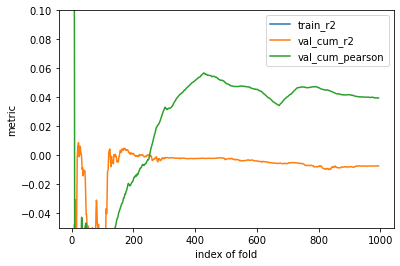

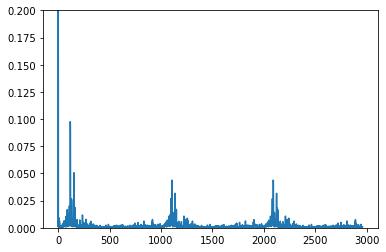

In [28]:
# lr step=100; nepoch=3; lookback=8; lr start=0.05, end=1e-11
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0, 0.2])
plt.show()

The ending score for metric train_r2 is: -2.2526e+01
The ending score for metric val_cum_r2 is: -1.0788e+00
The ending score for metric val_cum_pearson is: -1.3687e-04


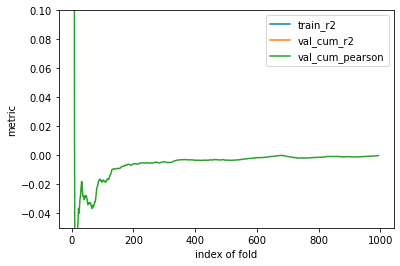

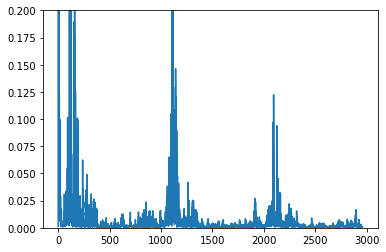

In [31]:
# lr step=500; nepoch=3; lookback=8; lr 0.1, end=0.003
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0, 0.2])
plt.show()

The ending score for metric train_r2 is: -4.2967e+02
The ending score for metric val_cum_r2 is: -4.2305e-02
The ending score for metric val_cum_pearson is: 1.0187e-02


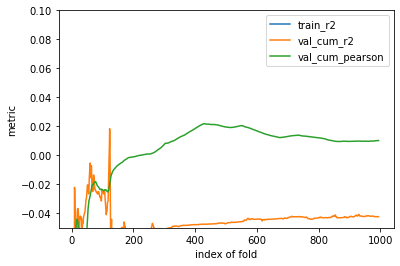

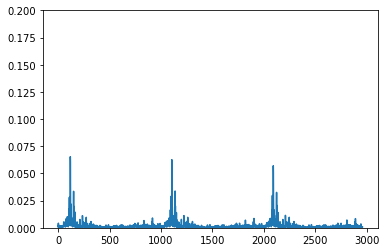

In [34]:
# no lr step; nepoch=3; lookback=8; lr start=1e-4
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0, 0.2])
plt.show()

The ending score for metric train_r2 is: -8.1909e+00
The ending score for metric val_cum_r2 is: -3.8061e-02
The ending score for metric val_cum_pearson is: 2.0547e-02


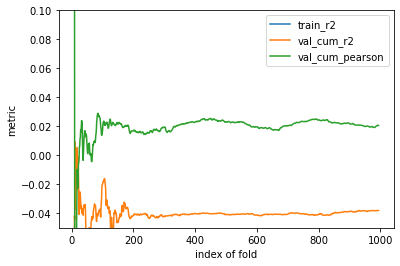

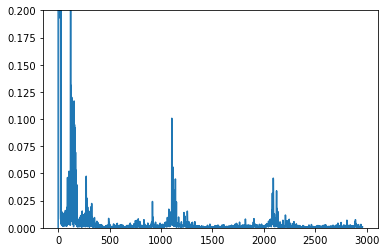

In [41]:
# lr step=200; nepoch=3; lookback=8; lr start=0.1 end=6e-6; hidden_size=512
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0, 0.2])
plt.show()

In [ ]:
# lr step=200; nepoch=100; lookback=8; lr start=5e-5
# Doesn't work

In [ ]:
# lr step=200; nepoch=3; lookback=8; lr start=0.1 end=6e-6, 2 layers
# but val r2 seems to decay nicely; a bit slow
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0, 0.2])
plt.show()

The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric val_cum_r2 is: -3.2609e-06


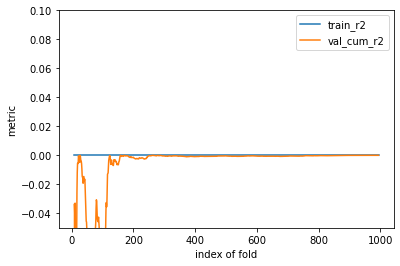

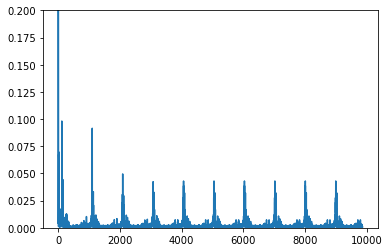

In [17]:
# lr step=300; nepoch=10; lookback=8; lr start=0.1 end=6e-6, 2 layers, 128 hidden
# doesn't work
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0, 0.2])
plt.show()

The ending score for metric train_r2 is: -7.0970e+02
The ending score for metric val_cum_r2 is: -2.8990e-03
The ending score for metric val_cum_pearson is: -5.5838e-02


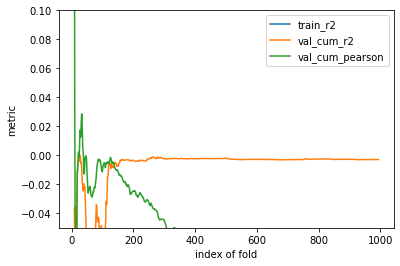

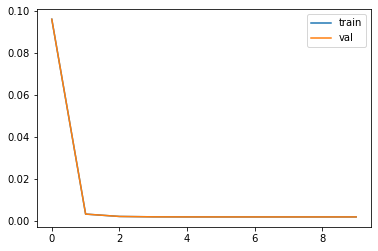

In [31]:
# lr step=300; nepoch=10; lookback=8; lr start=0.1 end=2e-11, 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.2])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -6.9504e+02
The ending score for metric val_cum_r2 is: -2.5562e-02
The ending score for metric val_cum_pearson is: -4.7640e-04


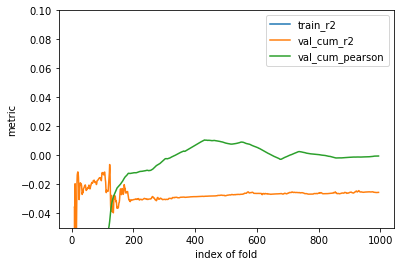

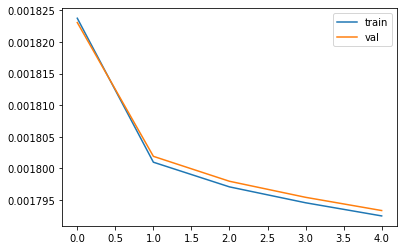

In [33]:
# no lr step; nepoch=5; lookback=8; lr 5e-5, 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.2])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -4.4243e+03
The ending score for metric val_cum_r2 is: 6.1596e-04
The ending score for metric val_cum_pearson is: 4.9299e-02


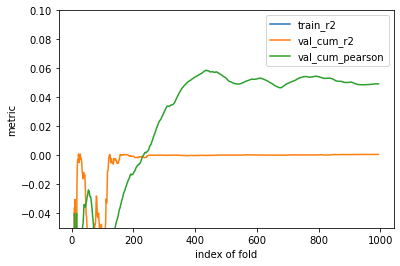

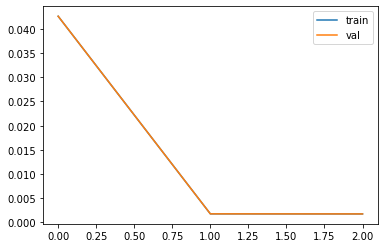

In [43]:
#lr step=100; nepoch=3; lookback=8; lr start 0.05, end 1e-11 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -7.1154e+03
The ending score for metric val_cum_r2 is: -4.4610e-05
The ending score for metric val_cum_pearson is: 3.7067e-02


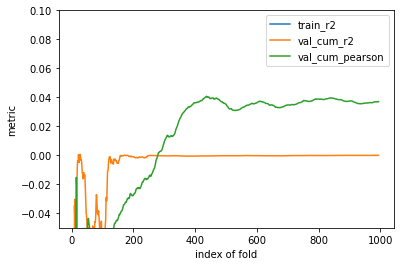

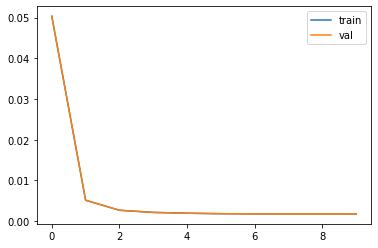

In [46]:
# lr step=500; nepoch=10; lookback=8; lr start 0.05, end 1e-11 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -3.7192e+02
The ending score for metric val_cum_r2 is: -1.1226e-03
The ending score for metric val_cum_pearson is: 4.5148e-02


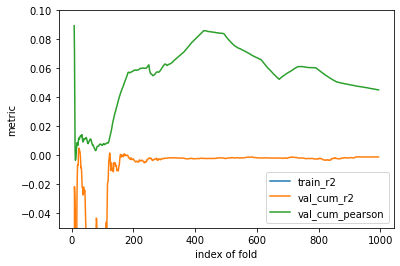

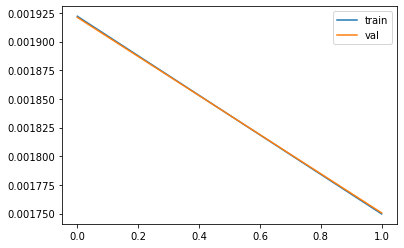

In [54]:
# lr step=100; nepoch=2; lookback=8; lr start 0.005, end 1e-9 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()


The ending score for metric train_r2 is: -2.0893e+02
The ending score for metric val_cum_r2 is: -1.8870e-03
The ending score for metric val_cum_pearson is: 2.9132e-02


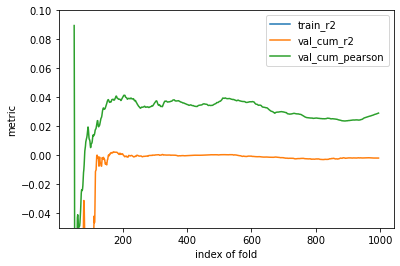

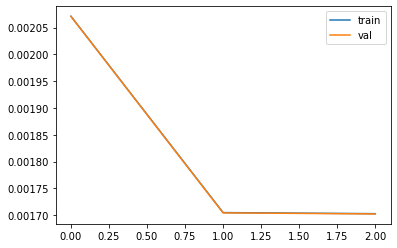

In [57]:
# lr step=100; nepoch=3; lookback=50; lr start 0.01, end 3e-11 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -8.2779e+01
The ending score for metric val_cum_r2 is: -2.2277e-02
The ending score for metric val_cum_pearson is: -4.3475e-03


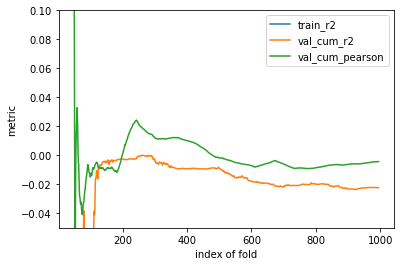

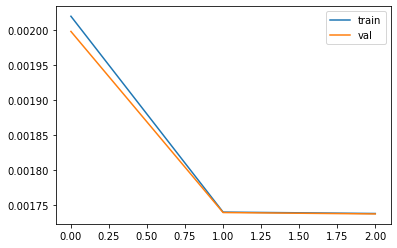

In [59]:
# lr step=100; nepoch=3; lookback=50; lr start 0.01, end 3e-11 1 layers, 32 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()



The ending score for metric train_r2 is: -2.1151e+01
The ending score for metric val_cum_r2 is: -5.1776e-02
The ending score for metric val_cum_pearson is: 1.6845e-01


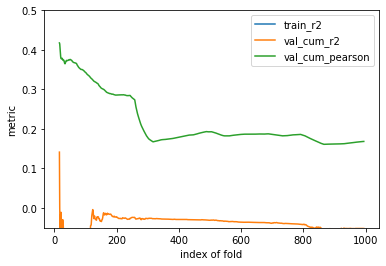

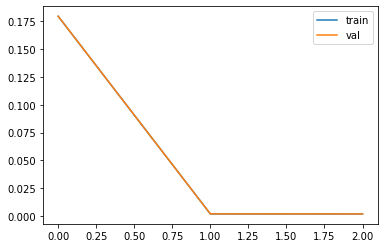

In [63]:
# lr step=100; nepoch=3; lookback=16; lr start 0.01, end 3e-11 1 layers, 1024 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch), val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

In [65]:
model_path = '../../model/dump/LSTM_1for54'
torch.save(net.state_dict(), model_path)



## Baseline case: use only old return:
- validation R_2 can achieve almost -0 using ADAM

In [22]:
quantized_fundamental, _ = data_quantization(dataset.fundamental)
df = pd.concat([quantized_fundamental, dataset.fundamental, dataset.ref_return], axis=1).dropna()
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                    'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']

check_dataframe(df, expect_index=['day', 'asset'], shutup=False)


Indices matched
Features matched
DataFame is all good for the tests


In [23]:
df['return_known'] = df['return'].shift(2 * 54)
df = df.dropna()


In [35]:

# Hyperparameter
n_splits = 995
n_epoch = 3
learning_rate = 0.05
lookback_window = 16
# Define loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# Define feature:
# feature_columns = quantile_feature
# feature_columns = original_featxure
feature_columns = ['return_known']
return_column = ['return']
num_feature = len(feature_columns)

# Define network
# net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,lookback_window,54), b_size=1)
net = oneDVerConvNet(D_in=num_feature, D_out=1, input_shape=(num_feature, lookback_window, 54), b_size=1)
# Define the optimizier
optimizer = optim.LBFGS(net.parameters(), lr=learning_rate)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

loss_list = []
# label_train_list = []
# test_list2 = []
# test_score_old = 0

days = df.index.get_level_values('day').unique()
tscv = TimeSeriesSplit(n_splits=min(n_splits, len(days)))

for epoch in range(n_epoch):
    pbar = tqdm(tscv.split(days), total=tscv.n_splits)
    cum_y_val_true = Series(dtype=float)
    cum_y_val_prediction = Series(dtype=float)
    performance = Performance()
    net.train()
    np.random.seed(44)
    # for epoch in range(n_epoch):
    for fold, (train, val) in enumerate(pbar):
        # X, _ = data_quantization(df[original_feature])
        running_loss = 0
        days_train = days[train]

        if len(days_train) < 2:
            print('Skipping this fold since we cannot truncate the last day.')
            continue
        if (lookback_window is not None) and (len(days_train) > lookback_window):
            cum_y_train_true = Series(dtype=float)
            cum_y_train_prediction = Series(dtype=float)

            days_train_valid = days_train[-lookback_window - 1:-1]  # last ends at valid-day-2
            X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid[-1]), :][
                return_column]

            X_np = X_train.swaplevel(1, 0).sort_index(ascending=True).to_numpy().astype(np.float32)
            # shape (asset, days, feature) -> (ft, days, asset)
            X_np_tensor = X_np.reshape(54, lookback_window, -1).transpose([2, 1, 0])
            X_np_tensor = X_np_tensor[np.newaxis, :]  # add batch dimension
            X_torch = torch.from_numpy(X_np_tensor)
            labels = torch.tensor(y_train_true['return'].values).to(torch.float)


            #
            def closure():
                optimizer.zero_grad()
                outputs = net(X_torch)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss


            optimizer.zero_grad()
            outputs = net(X_torch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step(closure)  # need closure for LBFGS
            # optimizer.step()

            scheduler.step()  ### !!!!!
            cum_y_train_prediction = pd.concat([cum_y_train_prediction, Series(outputs.detach().numpy())])
            cum_y_train_true = pd.concat([cum_y_train_true, y_train_true.squeeze()], ignore_index=True)

            performance[fold, 'train_r2'] = r2_score(cum_y_train_prediction, cum_y_train_true)
            if fold % 100 == 0:
                print('Fold [{}/{}], Loss: {:.4f}, cum_train_r2: {:.2f}%'.format(fold, len(pbar), loss.item(),
                                                                                 r2_score(cum_y_train_prediction,
                                                                                          cum_y_train_true)))
            # Validation:
            days_val = days[int(val) - lookback_window:int(val)]

            X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val[-1],), :][return_column]
            net.eval()
            net.train(False)
            with torch.no_grad():
                X_np_val = X_val.swaplevel(1, 0).sort_index(ascending=True).to_numpy().astype(np.float32)
                # shape (asset, days, feature) -> (ft, days, asset)
                X_np_val_tensor = X_np_val.reshape(54, lookback_window, -1).transpose([2, 1, 0])
                X_np_val_tensor = X_np_val_tensor[np.newaxis, :]  # add batch dimension
                X_torch_val = torch.from_numpy(X_np_val_tensor)
                labels = torch.tensor(y_val_true['return'].values).to(torch.float)

                outputs_val = net(X_torch_val)
                cum_y_val_prediction = pd.concat([cum_y_val_prediction, Series(outputs_val.numpy())])
                cum_y_val_true = pd.concat([cum_y_val_true, y_val_true.squeeze()], ignore_index=True)

            val_r2 = r2_score(y_val_true.squeeze(),
                              Series(outputs_val.numpy()))  # Do I need index for series to corr or R2?
            performance[fold, 'val_r2'] = val_r2
            val_pearson = y_val_true.squeeze().corr(Series(outputs_val.numpy()))
            performance[fold, 'val_pearson'] = val_pearson
            val_cum_r2 = r2_score(cum_y_val_true, cum_y_val_prediction)
            performance[fold, 'val_cum_r2'] = val_cum_r2
            val_cum_pearson = cum_y_val_true.corr(cum_y_val_prediction)
            performance[fold, 'val_cum_pearson'] = val_cum_pearson

            pbar.set_description(f'Fold {fold}, val_cum_r2={val_cum_r2:.4f}, val_cum_pearson={val_cum_pearson:.4f}')

        else:
            pass

        # if fold > 20:
        #     break
        # X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid,), :][return_column]
        # X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val,), :][return_column]

        #


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [100/995], Loss: 0.0032, cum_train_r2: -1274534.66%
Fold [200/995], Loss: 0.0017, cum_train_r2: -2280200.11%
Fold [300/995], Loss: 0.0009, cum_train_r2: -615003.87%
Fold [400/995], Loss: 0.0004, cum_train_r2: -586695.02%
Fold [500/995], Loss: 0.0004, cum_train_r2: -803927.17%
Fold [600/995], Loss: 0.0006, cum_train_r2: -1908007.20%
Fold [700/995], Loss: 0.0007, cum_train_r2: -946195.67%
Fold [800/995], Loss: 0.0012, cum_train_r2: -1575971.34%
Fold [900/995], Loss: 0.0004, cum_train_r2: -562351.15%


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [100/995], Loss: 0.0032, cum_train_r2: -1274622.31%
Fold [200/995], Loss: 0.0017, cum_train_r2: -2280191.03%
Fold [300/995], Loss: 0.0009, cum_train_r2: -615003.87%
Fold [400/995], Loss: 0.0004, cum_train_r2: -586692.69%
Fold [500/995], Loss: 0.0004, cum_train_r2: -803927.17%
Fold [600/995], Loss: 0.0006, cum_train_r2: -1908033.95%
Fold [700/995], Loss: 0.0007, cum_train_r2: -946192.65%
Fold [800/995], Loss: 0.0012, cum_train_r2: -1575956.92%
Fold [900/995], Loss: 0.0004, cum_train_r2: -562350.45%


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [100/995], Loss: 0.0032, cum_train_r2: -1274622.31%
Fold [200/995], Loss: 0.0017, cum_train_r2: -2280191.03%
Fold [300/995], Loss: 0.0009, cum_train_r2: -615003.87%
Fold [400/995], Loss: 0.0004, cum_train_r2: -586692.69%
Fold [500/995], Loss: 0.0004, cum_train_r2: -803927.17%
Fold [600/995], Loss: 0.0006, cum_train_r2: -1908033.95%
Fold [700/995], Loss: 0.0007, cum_train_r2: -946192.65%
Fold [800/995], Loss: 0.0012, cum_train_r2: -1575956.92%
Fold [900/995], Loss: 0.0004, cum_train_r2: -562350.45%


In [15]:
# define input sequence
in_seq1 = np.array([x for x in range(0, 100, 10)])
in_seq2 = np.array([x for x in range(5, 105, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])

In [16]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [17]:
# horizontally stack columns
test = np.hstack((in_seq1, in_seq2, out_seq))

The ending score for metric train_r2 is: -7.6914e+05
The ending score for metric val_cum_r2 is: -3.1575e-04
The ending score for metric val_cum_pearson is: 1.8511e-02


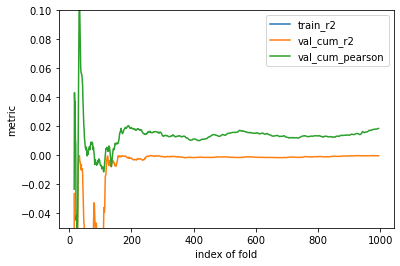

In [36]:
plt.figure()
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson', 'val_cum_r2'])
plt.show()

In [34]:
performance

In [219]:
model_path = '../../model/dump/1DConv'
torch.save(net.state_dict(), model_path)


In [221]:
from qids_lib import QIDS
from pipeline.backtest import evaluation_for_submission

dataset = Dataset.load('../data/parsed')
df = pd.concat([dataset.fundamental, extract_market_data(dataset.market)], axis=1).dropna()
df['return_known'] = df['return'].shift(2 * 54)
df = df.dropna()
f_quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                      'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE', 'return_known']
m_quantile_feature = ['avg_price_QUANTILE', 'volatility_QUANTILE', 'mean_volume_QUANTILE', 'return_known']
# feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'avg_price', 'volatility',
#            'mean_volume']


# q_df, _ = data_quantization(dataset.fundamental)
# full_df = pd.concat([q_df, dataset.ref_return], axis=1).dropna()
# model = linear_model(full_df[f_quantile_feature], full_df['return'])

qids = QIDS(path_prefix='../')


